# SARIMAX

## 1. Setup

### 1.1 Load data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load and merge data
df_observed = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)
df_forecasts = pd.read_csv(
    os.path.join(data_dir, "neso_forecasts.csv"),
    parse_dates=["TARGET_DATE", "ISSUE_DATE"],
)

df_observed.sort_values(
    ["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"], 
    inplace=True
)
df_forecasts.sort_values(
    ["TARGET_DATE", "TARGET_PERIOD", "ISSUE_DATE", "ISSUE_PERIOD"],
    inplace=True,
)

# Check for NaNs
if df_observed.isna().values.any():
    print("Warning: BMRS dataset contains null values.")

if df_forecasts.isna().values.any():
    print("Warning: NESO dataset contains null values.")

df = df_observed.merge(
    df_forecasts,
    left_on=["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"],
    right_on=["TARGET_DATE", "TARGET_PERIOD"],
    how="left",
)

### 1.2 Create features

In [2]:
from utilities.datatools import create_timestamps

# Create explicit timestamps for better visualisation later
df["TIMESTAMP"] = create_timestamps(
    df,
    date_column="SETTLEMENT_DATE",
    period_column="SETTLEMENT_PERIOD",
    tz="Europe/London"
)

# Timestamps and endogenous variable
price_col = "ELECTRICITY_PRICE"
date_col = "SETTLEMENT_DATE"
period_col = "SETTLEMENT_PERIOD"
timestamp_col = "TIMESTAMP"

In [3]:
# Exogenous variables

from utilities.features import is_holiday, is_weekend

# Temporal features
sp = df["SETTLEMENT_PERIOD"]
df["period_sin"] = np.sin(4 * np.pi * (sp - 1) / 48)
df["period_cos"] = np.cos(4 * np.pi * (sp - 1) / 48)

dow = df["SETTLEMENT_DATE"].dt.dayofweek
df["dayofweek_sin"] = np.sin(2 * np.pi * dow / 7)
df["dayofweek_cos"] = np.cos(2 * np.pi * dow / 7)

month = df["SETTLEMENT_DATE"].dt.month
df["month_sin"] = np.sin(2 * np.pi * (month - 1) / 12)
df["month_cos"] = np.cos(2 * np.pi * (month - 1) / 12)

df["is_holiday"] = is_holiday(df, "SETTLEMENT_DATE", country="GB")
df["is_weekend"] = is_weekend(df, "SETTLEMENT_DATE")

# Exogenous features
df["demand_train"] = df["INDO"]
df["wind_train"] = df["WIND"]
df["demand_forecast"] = df["DEMAND_FORECAST"]
df["wind_forecast"] = df["WIND_FORECAST"]

# Define feature columns
temporal_features = [
    "period_sin",
    "period_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "month_sin",
    "month_cos",
    "is_holiday",
    "is_weekend",
]

# Note: ARIMA converges better without demand and wind variables,
# so they've been dropped for now.
train_feature_cols = temporal_features #+ ["demand_train", "wind_train"]
forecast_feature_cols = temporal_features #+ ["demand_forecast", "wind_forecast"]

# Drop unnecessary columns
cols = set(
    [price_col, date_col, period_col, timestamp_col]
    +
    train_feature_cols + forecast_feature_cols
)
df = df[list(cols)].copy()

## 2. Make a simple forecast

### 2.1 Train-test split

In [4]:
endog = df[price_col]
exog_train = df[train_feature_cols]

# Train/test split by date
n_train = 48 * 7  # 1 week of training data
n_test = 48 * 2  # 2 days of test data

# Train set (reset index to start from 0)
df_train = df.iloc[-(n_train + n_test) : -n_test].reset_index(drop=True)
endog_train = df_train[price_col]
exog_train = df_train[train_feature_cols]

# Test set (index continues from train set)
df_test = df.iloc[-n_test:].reset_index(drop=True)
df_test.index += len(df_train)
endog_test = df_test[price_col]
exog_test = df_test[forecast_feature_cols]

### 2.2 Specify model parameters

In [5]:
import statsmodels.api as sm

# Chosen based on ACF/PACF plots in `analysis/electricity_prices.ipynb`
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 48)

model = sm.tsa.SARIMAX(
    endog=endog_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_train,
)

model_fitted = model.fit()

/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 2.3 Make forecast

In [6]:
from utilities.evaluation import rmse, mae

point_forecast = model_fitted.forecast(steps=n_test, exog=exog_test)

# Compute forecasting error
print(f"RMSE: {rmse(point_forecast, np.asarray(endog_test)):.2f} £/MWh")
print(f"MAE: {mae(point_forecast, np.asarray(endog_test)):.2f} £/MWh")

RMSE: 36.87 £/MWh
MAE: 33.71 £/MWh


### 2.4 Visualise results

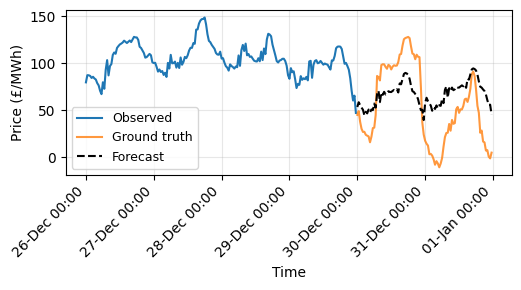

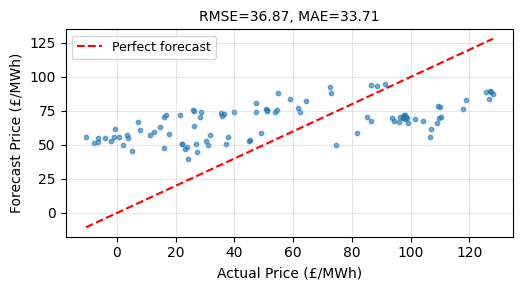

In [7]:
import matplotlib.dates as mdates

# Get data for plotting
train_tail = df_train.iloc[-(2 * n_test):]
test_data = df_test

# Time series plot with timestamps
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(train_tail[timestamp_col], train_tail[price_col], label="Observed")
ax.plot(test_data[timestamp_col], test_data[price_col], label="Ground truth", alpha=0.8)
ax.plot(test_data[timestamp_col], point_forecast, ls="--", color="k", label="Forecast")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot with time-of-day color coding
fig, ax = plt.subplots(figsize=(16 / 3, 3), layout="tight")

# Color by settlement period
scatter = ax.scatter(test_data[price_col], point_forecast, alpha=0.6, s=10)

# Perfect forecast line
ax.plot(
    [test_data[price_col].min(), test_data[price_col].max()],
    [test_data[price_col].min(), test_data[price_col].max()],
    "r--", label="Perfect forecast"
)

ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)

y_pred = np.asarray(point_forecast)
y_true = np.asarray(test_data[price_col])
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

Study the residuals of the forecast:

/var/folders/r2/fdwz5hy15238clh3yp9jsd5m0000gn/T/ipykernel_65750/4267809568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=9)


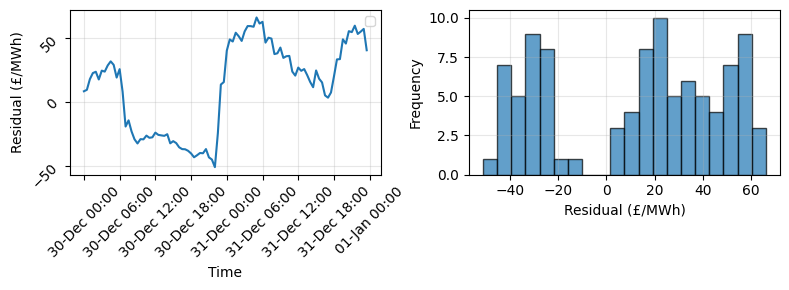

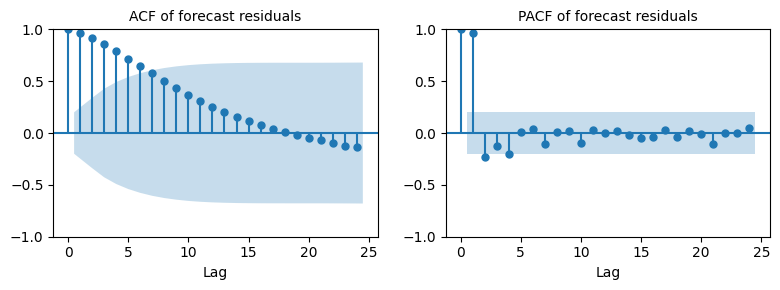

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute test residuals
resi = point_forecast - endog_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
# Line plot of residuals
inds = resi.index
ax1.plot(df_test.loc[inds][timestamp_col], resi)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
ax1.set_xlabel("Time", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.tick_params(rotation=45)

# Histogram of residuals
ax2.hist(resi, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.grid(True, alpha=0.3)
plt.show()

# Plot (partial) autocorrelations of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")

# ACF
plot_acf(resi, lags=24, ax=ax1)
ax1.set_title("ACF of forecast residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

# PACF
plot_pacf(resi, lags=24, ax=ax2)
ax2.set_title("PACF of forecast residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

### 2.5 Bootstrapping the residuals 

To compute confidence intervals on the forecasts, conditional sieve
bootstrapping is used. The bootstrapping procedure goes as follows:

1. Get residuals $X_k$ from the fitted model
2. Fit a sieve / autoregressive model (AR($p$)) to the residuals $X_k$
3. Centre the residuals $\epsilon_k$ from the sieve to get $\hat{\epsilon}_k = \epsilon_k - \mu$
4. Bootstrap (with resampling) the centered residuals to get $\epsilon_k^{* (b)}$
5. Generate residual paths $X^{* (b)}_{k+1} = \sum^p_j{\hat{\phi}_j X^{* (b)}_{k+1-j}}+ \epsilon^{* (b)}_{k+1}$
6. Generate forecast paths $Y^{* (b)}_{k+1} = \hat{Y}_{k+1} + X^{* (b)}_{k+1}$

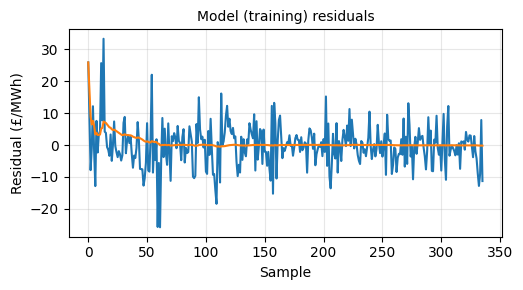

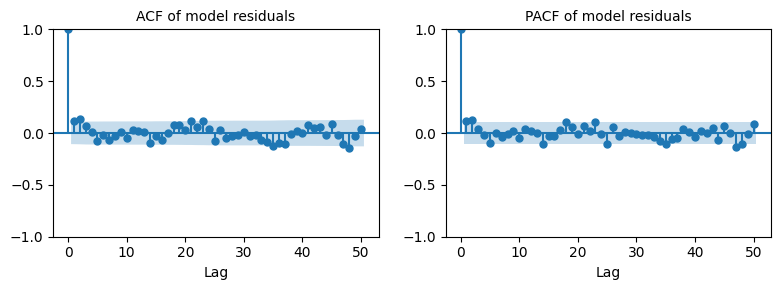


Mean of sieve residuals: -0.000000
Standard deviation of sieve residuals: 4.90


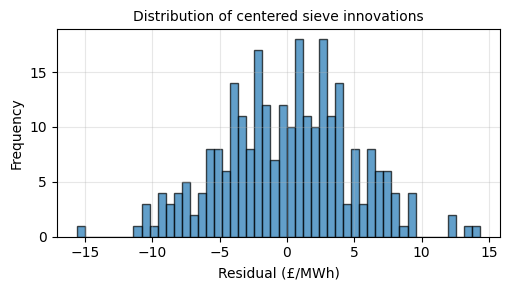

In [9]:
## Checks to validate that sieve bootstrapping is an acceptable method

# Get model residuals (X_k)
model_resid = model_fitted.resid

# Visualise model residuals
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(model_resid, label="Residuals")
ax.plot(model_resid.expanding().mean(), label="Mean")
ax.set_xlabel("Sample", fontsize=10)
ax.set_ylabel("Residual (£/MWh)", fontsize=10)
ax.set_title("Model (training) residuals", fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# Check ACF/PACF of model residuals to determine AR order
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(model_resid, lags=50, ax=ax1)
ax1.set_title("ACF of model residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)
plot_pacf(model_resid, lags=50, ax=ax2)
ax2.set_title("PACF of model residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

# Step 2: Fit AR(p) sieve model to residuals
n = len(resi)
p_sieve = int(n / np.log(n) ** (1/4)) + 1
sieve_model = sm.tsa.AutoReg(model_resid, lags=p_sieve, old_names=False)
sieve_fitted = sieve_model.fit()

# print(f"\nSieve AR({p_sieve}) model summary:")
# print(sieve_fitted.summary())

# Step 3: Get innovations (epsilon_k) from sieve and center them
sieve_resid = sieve_fitted.resid
epsilon_centered = sieve_resid - sieve_resid.mean()

print(f"\nMean of sieve residuals: {sieve_resid.mean():.6f}")
print(f"Standard deviation of sieve residuals: {sieve_resid.std():.2f}")

# Visualise sieve residuals
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.hist(epsilon_centered, bins=50, edgecolor="black", alpha=0.7)
ax.set_xlabel("Residual (£/MWh)", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
ax.set_title("Distribution of centered sieve innovations", fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

In [10]:
from utilities.bootstrap import cond_sieve_bootstrap

n_bootstrap = 500  # Number of bootstrap samples

bootstrap_paths = cond_sieve_bootstrap(
    model_resid,
    point_forecast,
    n_bootstrap,
    seed=0
)

# Compute bootstrap confidence intervals
ci_lower = np.percentile(bootstrap_paths, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_paths, 97.5, axis=0)
ci_median = np.percentile(bootstrap_paths, 50, axis=0)

print(f"Bootstrap completed with {n_bootstrap} samples")
print(f"Mean CI width: {np.mean(ci_upper - ci_lower):.2f} £/MWh")

Bootstrap completed with 500 samples
Mean CI width: 25.53 £/MWh


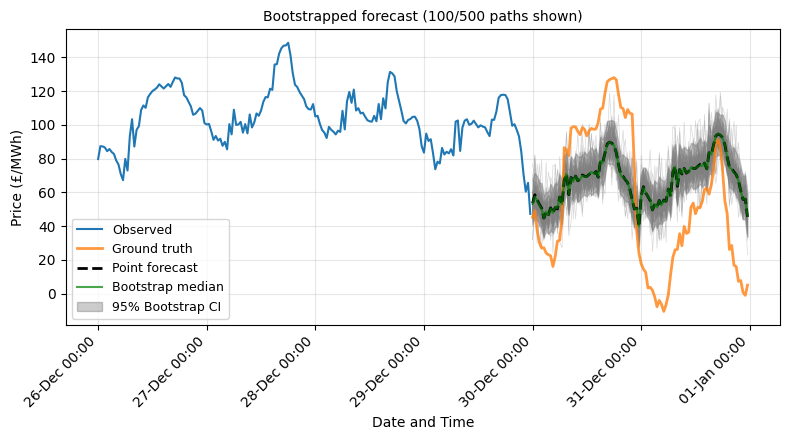

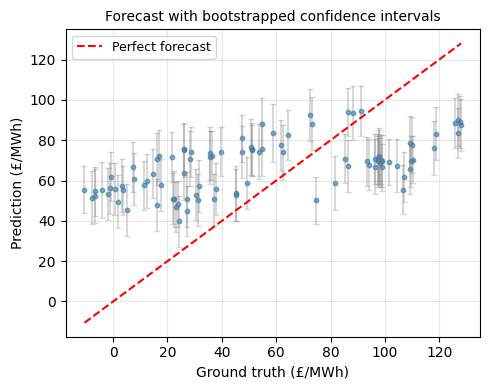

In [11]:
# Visualise bootstrap paths with timestamps
fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="tight")

# Use timestamps
test_timestamps = df_test["TIMESTAMP"]
train_tail = df_train.iloc[-(2 * n_test):]

# Plot a sample of bootstrap paths
n_sample = 100
for b in range(n_sample):
    ax.plot(
        test_timestamps, bootstrap_paths[b, :], 
        color="gray", alpha=0.3, linewidth=0.5
    )

# Plot training data tail
ax.plot(
    train_tail["TIMESTAMP"], train_tail[price_col],
    label="Observed", color="C0"
)

# Plot ground truth
ax.plot(
    test_timestamps, df_test[price_col],
    label="Ground truth", color="C1", linewidth=2, alpha=0.8
)

# Plot point forecast
ax.plot(
    test_timestamps, point_forecast,
    "k--", label="Point forecast", linewidth=2
)

# Plot confidence intervals
ax.plot(
    test_timestamps, ci_median, "g-", 
    label="Bootstrap median", linewidth=1.5, alpha=0.7
)
ax.fill_between(
    test_timestamps, ci_lower, ci_upper, 
    color="k", alpha=0.2, label="95% Bootstrap CI"
)

# Format x-axis (international style)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
ax.set_xlabel("Date and Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Bootstrapped forecast ({n_sample}/{n_bootstrap} paths shown)", fontsize=10)
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot with bootstrapped uncertainties
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(df_test[price_col], point_forecast, alpha=0.6, s=10,)
ci_half_width = (ci_upper - ci_lower) / 2
ax.errorbar(
    df_test[price_col].values, point_forecast, yerr=ci_half_width,
    fmt="none", ecolor="gray", alpha=0.3, capsize=2
)

# Perfect forecast line
ax.plot(
    [df_test[price_col].min(), df_test[price_col].max()],
    [df_test[price_col].min(), df_test[price_col].max()],
    "r--", label="Perfect forecast"
)

ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.set_title("Forecast with bootstrapped confidence intervals", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 3. Rolling day-ahead forecast evaluation

We now implement a rolling forecast where we:
1. Fit the model on a window of historical data
2. Forecast tomorrow's prices using NESO forecasts
3. Bootstrap the residuals to get confidence intervals
4. Update the model with latest observations and drop the oldest observations
5. Move on to the next day and repeat

### 3.1 Setup

In [12]:
import datetime as dt

# Rolling forecast parameters
n_train_samples = 48 * 7  # 1 weeks of training data
forecast_days = 7  # Number of day-ahead forecasts
issue_period = 18  # Issue forecast at 09:00 (period 18)
n_bootstrap = 500  # Bootstrap samples per forecast

print("Rolling forecast configuration:")
print(f"  Training set size: {n_train_samples} samples")
print(f"  Forecast days: {forecast_days}")
print(f"  Issue time: Period {issue_period}")
print(f"  Bootstrap samples: {n_bootstrap}")

# Create issue dates
start_date = dt.date(2024, 11, 1)
end_date = start_date + pd.Timedelta(days=forecast_days)
issue_dates = pd.date_range(start_date, end_date, freq="D")

print("\nDates on which forecasts are issued:")
print(f"  First: {issue_dates[0].date()}")
print(f"  Last: {issue_dates[-1].date()}")
print(f"  Total: {len(issue_dates)} days")

# Model specification
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)

print("\nModel specification:")
print(f"  (p, d, q): {order}")
print(f"  (P, D, Q, S): {seasonal_order}")

Rolling forecast configuration:
  Training set size: 336 samples
  Forecast days: 7
  Issue time: Period 18
  Bootstrap samples: 500

Dates on which forecasts are issued:
  First: 2024-11-01
  Last: 2024-11-08
  Total: 8 days

Model specification:
  (p, d, q): (1, 1, 1)
  (P, D, Q, S): (0, 1, 1, 48)


### 3.2 Forecast

In [13]:
from utilities.forecast import rolling_dayahead_forecast

# Initialise model on first training window
# Find index for first issue date
issue_mask = (df[date_col] == issue_dates[0]) & (df[period_col] == issue_period)
issue_idx = df[issue_mask].index[0]

# Get initial training window
train_start = issue_idx - n_train_samples
train_end = issue_idx

# Extract training data
train_df = df.iloc[train_start:train_end]
train_endog = train_df[price_col]
train_exog = train_df[train_feature_cols]

# Create and fit initial model
model = sm.tsa.SARIMAX(
    endog=train_endog,
    exog=train_exog,
    order=order,
    seasonal_order=seasonal_order,
)
fitted_model = model.fit(disp=False)

print(f"Model initialised on {len(train_endog)} samples")

print("Running rolling forecast...")
results = rolling_dayahead_forecast(
    fitted_model,
    df,
    issue_dates,
    issue_period,
    n_train_samples,
    endog_col=price_col,
    date_col=date_col,
    period_col=period_col,
    exog_cols_fit=train_feature_cols,
    exog_cols_predict=forecast_feature_cols,
    percentiles=[2.5, 97.5],
    n_bootstrap=n_bootstrap,
    seed=0,
    verbose=True,
)

# Summary statistics
rmse_val = np.sqrt(np.mean((results["forecast"] - results["actual"]) ** 2))
in_ci = (results["actual"] >= results["p2.5"]) & (results["actual"] <= results["p97.5"])
coverage = in_ci.mean() * 100

print("\n" + "=" * 50)
print("RESULTS SUMMARY")
print("=" * 50)
print(f"Total forecasts: {len(results)} periods")
print(f"RMSE: {rmse_val:.2f} £/MWh")
print(f"95% CI Coverage: {coverage:.1f}%")
print(f"Mean CI width: {(results['p97.5'] - results['p2.5']).mean():.2f} £/MWh")

/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model initialised on 336 samples
Running rolling forecast...
[1/8] Forecasting from 2024-11-01 00:00:00
  RMSE: 10.72, MAE: 8.66


/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[2/8] Forecasting from 2024-11-02 00:00:00
  RMSE: 8.17, MAE: 6.74


/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3/8] Forecasting from 2024-11-03 00:00:00
  RMSE: 21.04, MAE: 13.89
[4/8] Forecasting from 2024-11-04 00:00:00
  RMSE: 24.20, MAE: 17.54
[5/8] Forecasting from 2024-11-05 00:00:00
  RMSE: 8.68, MAE: 7.03
[6/8] Forecasting from 2024-11-06 00:00:00
  RMSE: 23.37, MAE: 20.67
[7/8] Forecasting from 2024-11-07 00:00:00
  RMSE: 12.79, MAE: 10.26
[8/8] Forecasting from 2024-11-08 00:00:00
  RMSE: 13.43, MAE: 10.73

RESULTS SUMMARY
Total forecasts: 384 periods
RMSE: 16.49 £/MWh
95% CI Coverage: 71.9%
Mean CI width: 28.69 £/MWh


### 3.3 Results

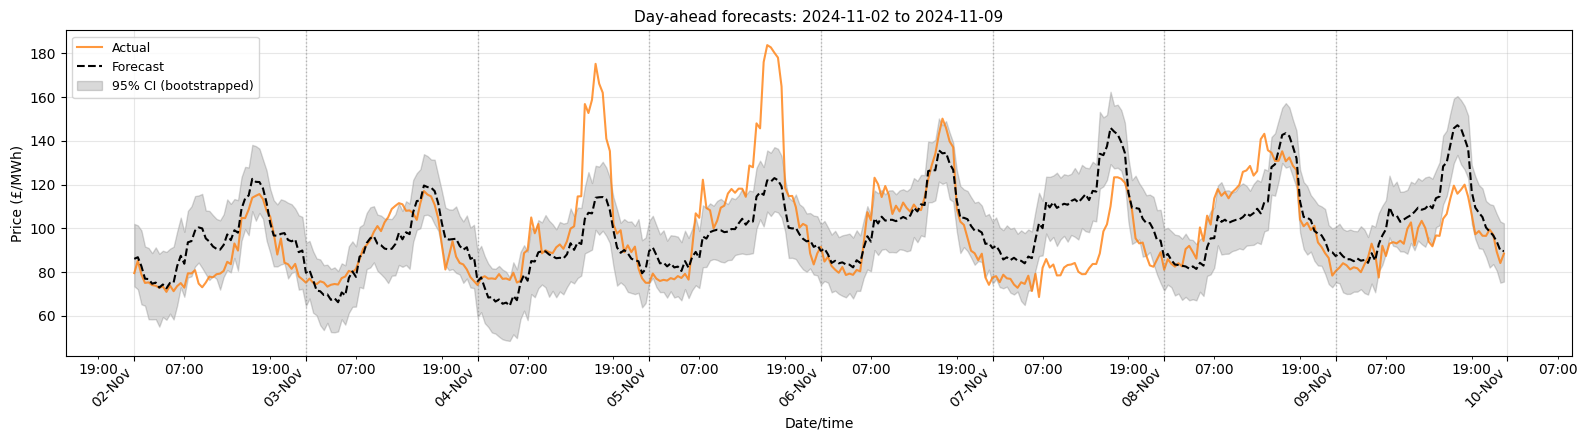

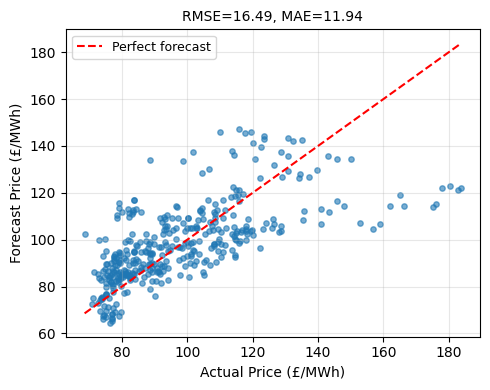

In [14]:
from utilities.evaluation import mae, rmse
import matplotlib.dates as mdates
from utilities.datatools import create_timestamps

# Create timestamps for results
results[timestamp_col] = create_timestamps(
    results,
    date_column=date_col,
    period_column=period_col,
    tz="Europe/London"
)

# Main time series plot with day boundaries
fig, ax = plt.subplots(figsize=(16, 9 / 2), layout="tight")

ts = results[timestamp_col]
ax.plot(ts, results["actual"], "C1", label="Actual", linewidth=1.5, alpha=0.8)
ax.plot(ts, results["forecast"], "k--", label="Forecast", linewidth=1.5)

# Confidence intervals
ax.fill_between(
    ts, results["p2.5"], results["p97.5"], 
    color="k", alpha=0.15, label="95% CI (bootstrapped)"
)

# Add vertical lines at midnight (day boundaries)
unique_dates = results[date_col].unique()
for date in unique_dates[1:]:  # Skip first day
    midnight = pd.Timestamp(date, tz="Europe/London")
    ax.axvline(midnight, color="gray", linestyle=":", alpha=0.5, linewidth=1)

# Format x-axis to show dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))

# Labels and title
date_range = f"{unique_dates[0].date()} to {unique_dates[-1].date()}"
ax.set_xlabel("Date/time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Day-ahead forecasts: {date_range}", fontsize=11)
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(results["actual"], results["forecast"], alpha=0.6, s=15)
ax.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--", label="Perfect forecast", linewidth=1.5
)

_rmse = rmse(results["forecast"].values, results["actual"].values)
_mae = mae(results["forecast"].values, results["actual"].values)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()